# imports

In [62]:
import pandas as pd
import numpy as np
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
import xgboost as xgb

# Data

In [2]:
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/'
df_post = pd.read_csv(p+'submissions_pmaw_2016-2021_wsb.csv',usecols=['author','created_utc','score','num_comments','title','selftext','id','award_count'])
df_post = df_post[df_post['author'] != '[deleted]']
len1=len(df_post.loc[df_post['award_count'] > 0])
len2=len(df_post.loc[df_post['award_count'] == 0])

In [3]:
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/graph_features_3/'
file_names=os.listdir(p)

data = []

for name in file_names:
    data.append(pd.read_csv(p+name))

df_gf=pd.concat(data)

df_balanced = pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/balanced_data_chunked10.csv')

In [4]:
df_gf.drop_duplicates(inplace=True)
df=df_balanced.join(df_gf.set_index('id'),on='id')
df.dropna(subset='degree',inplace=True)
df=df[['author', 'date', 'score', 'n_comments', 'id',
       'n_awards', 'text_title', 'degree_cen',
       	'close_cen','activity',	'degree','N_nodes',
        'N_edges','mentions','frac_rec',	
        'degree_in','degree_out']]

df.loc[df.n_awards==0,'awarded']=0
df.loc[df.n_awards!=0,'awarded']=1

df['n_comments']=df.n_comments.apply(lambda x: np.sqrt(x**2))

df['date'] = pd.to_datetime(df['date'])

In [5]:
def get_sentiment(text):
    if type(text) == str:
        com = sia.polarity_scores(text)['compound']
        return com
    else:
        return np.nan

def text_length(text):
    if type(text) == str:
        return len(text)
    else:
        return np.nan

df['sentiment_compound']=df['text_title'].apply(lambda x: get_sentiment(x))
df['text_length']=df['text_title'].apply(lambda x: text_length(x))

In [6]:
# drop AutoModerater posts
df=df[df.author!='AutoModerator']

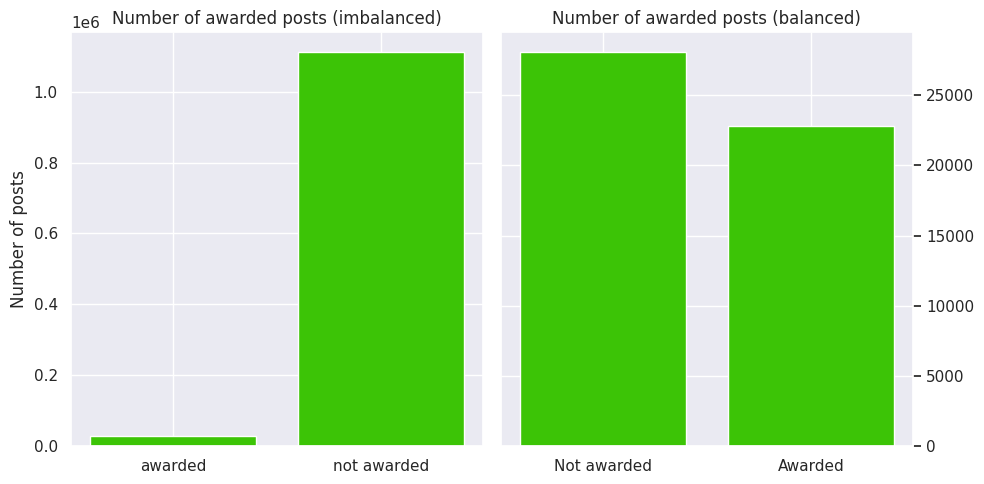

In [7]:
# subplots
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].bar(['awarded','not awarded'],[len1,len2],color='#3cc406')
ax[0].set_title('Number of awarded posts (imbalanced)')
ax[0].set_ylabel('Number of posts')
ax[1].bar(['Not awarded','Awarded'],df.awarded.value_counts(),color='#3cc406')
ax[1].set_title('Number of awarded posts (balanced)')
# ax[1].set_ylabel('Number of posts')
# set y axis on the right
ax[1].yaxis.tick_right()
plt.tight_layout()
plt.show()

In [8]:
df = df.sample(frac = 1)

# Analysis

In [9]:
df_no = df.loc[df.degree!=0]

### Temporal

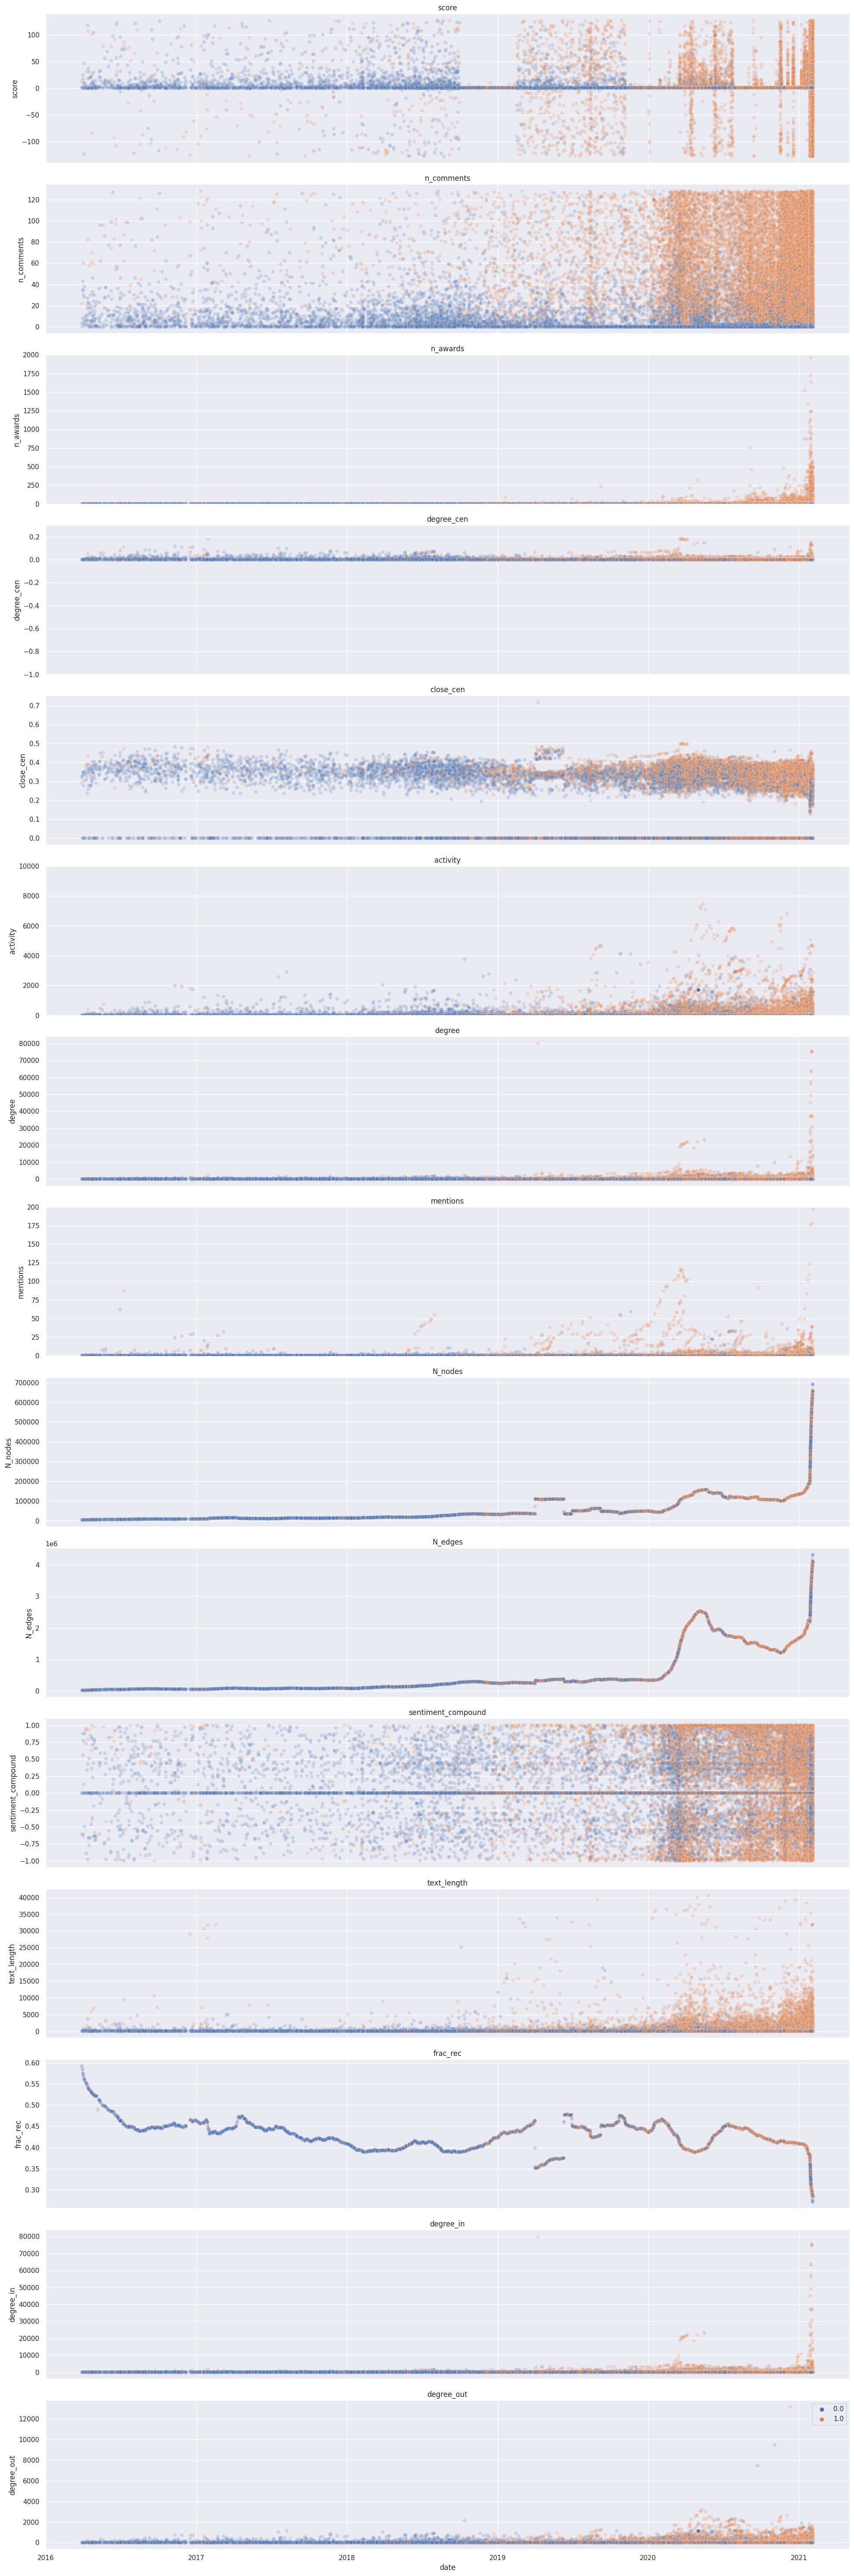

In [10]:
# subplots share x
features =['score', 'n_comments','n_awards','degree_cen', 
            'close_cen', 'activity', 'degree', 'mentions', 
            'N_nodes', 'N_edges','sentiment_compound','text_length','frac_rec','degree_in','degree_out']


fig, axs = plt.subplots(len(features), 1, figsize=(20,4*len(features)), sharex=True)


for val in features:
    sns.scatterplot(data=df, x='date', y=val, hue='awarded', ax=axs[features.index(val)], alpha=0.2,s=40)
    axs[features.index(val)].set_title(val)
    # legend false
    axs[features.index(val)].get_legend().remove()

    if val == 'degree_cen':
        axs[features.index(val)].set_ylim(-1,0.3)
    if val == 'n_awards':
        axs[features.index(val)].set_ylim(-1,2000)
    if val == 'activity':
        axs[features.index(val)].set_ylim(-1,10000)
    if val == 'mentions':
        axs[features.index(val)].set_ylim(-1,200)




plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_5337/6271199.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  rho = df.corr()
/tmp/ipykernel_5337/6271199.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)


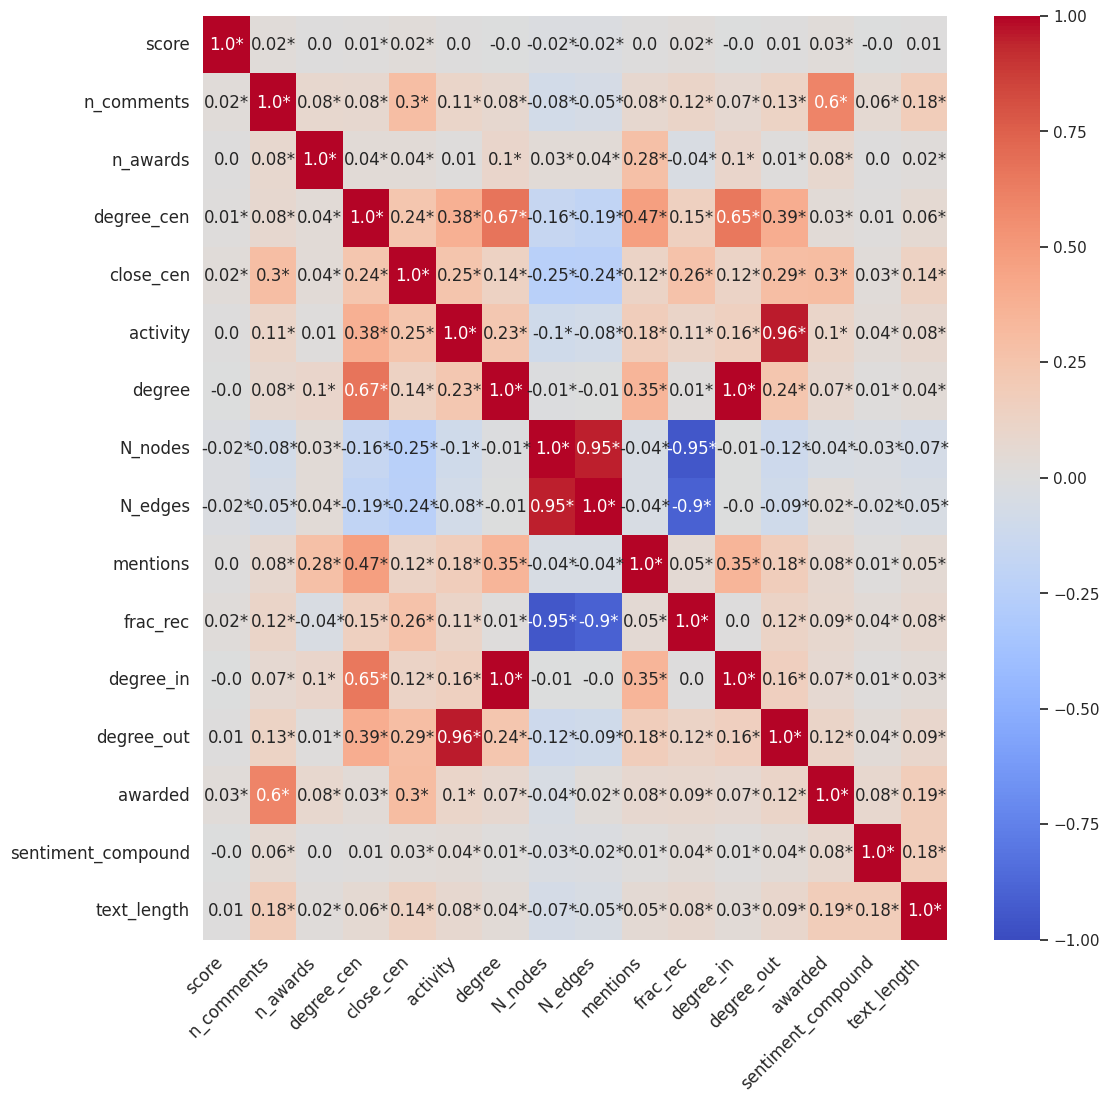

In [11]:
rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t]))

fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(data=rho, annot=(np.array(rho.round(2).astype(str) + p)),fmt = '',vmin=-1,vmax=1,cmap='coolwarm')

# rotate xticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
plt.savefig('correlation_matrix.png',dpi=300)
plt.show()

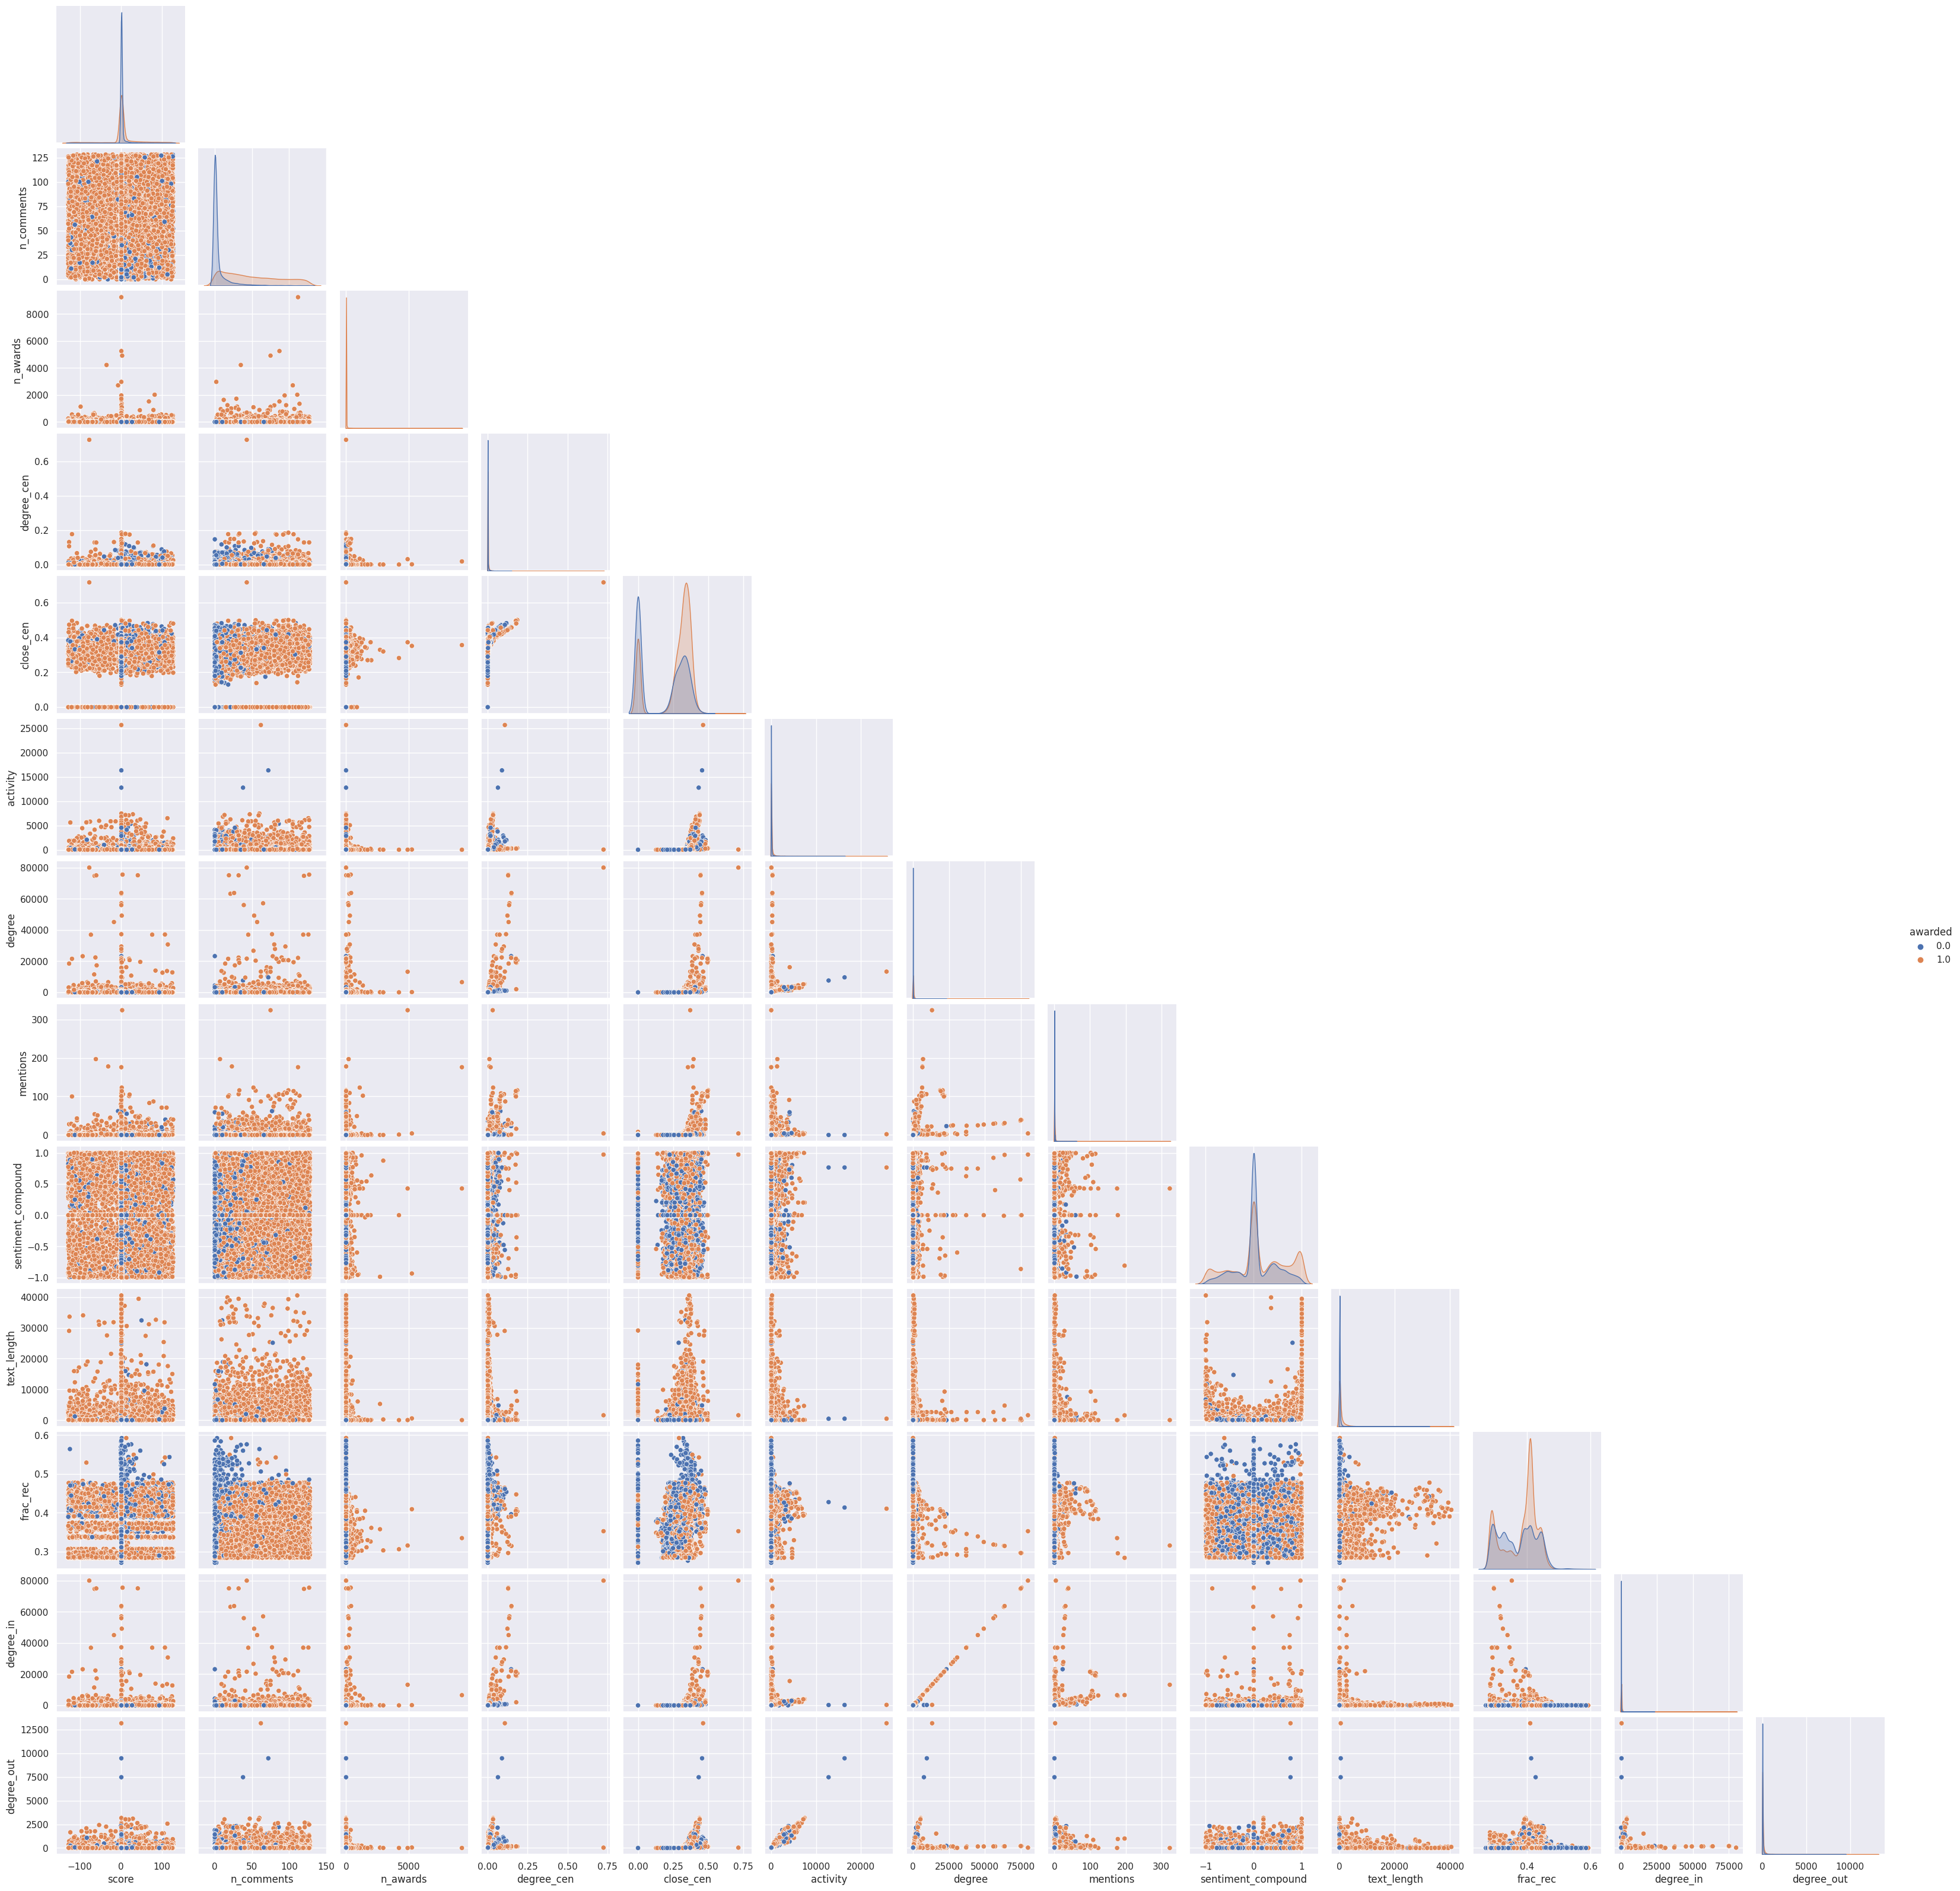

In [12]:
sns.pairplot(df, hue='awarded', vars=['score', 'n_comments','n_awards','degree_cen', 
                                    'close_cen', 'activity', 'degree', 'mentions', 
                                    'sentiment_compound','text_length','frac_rec','degree_in','degree_out'],corner=True)

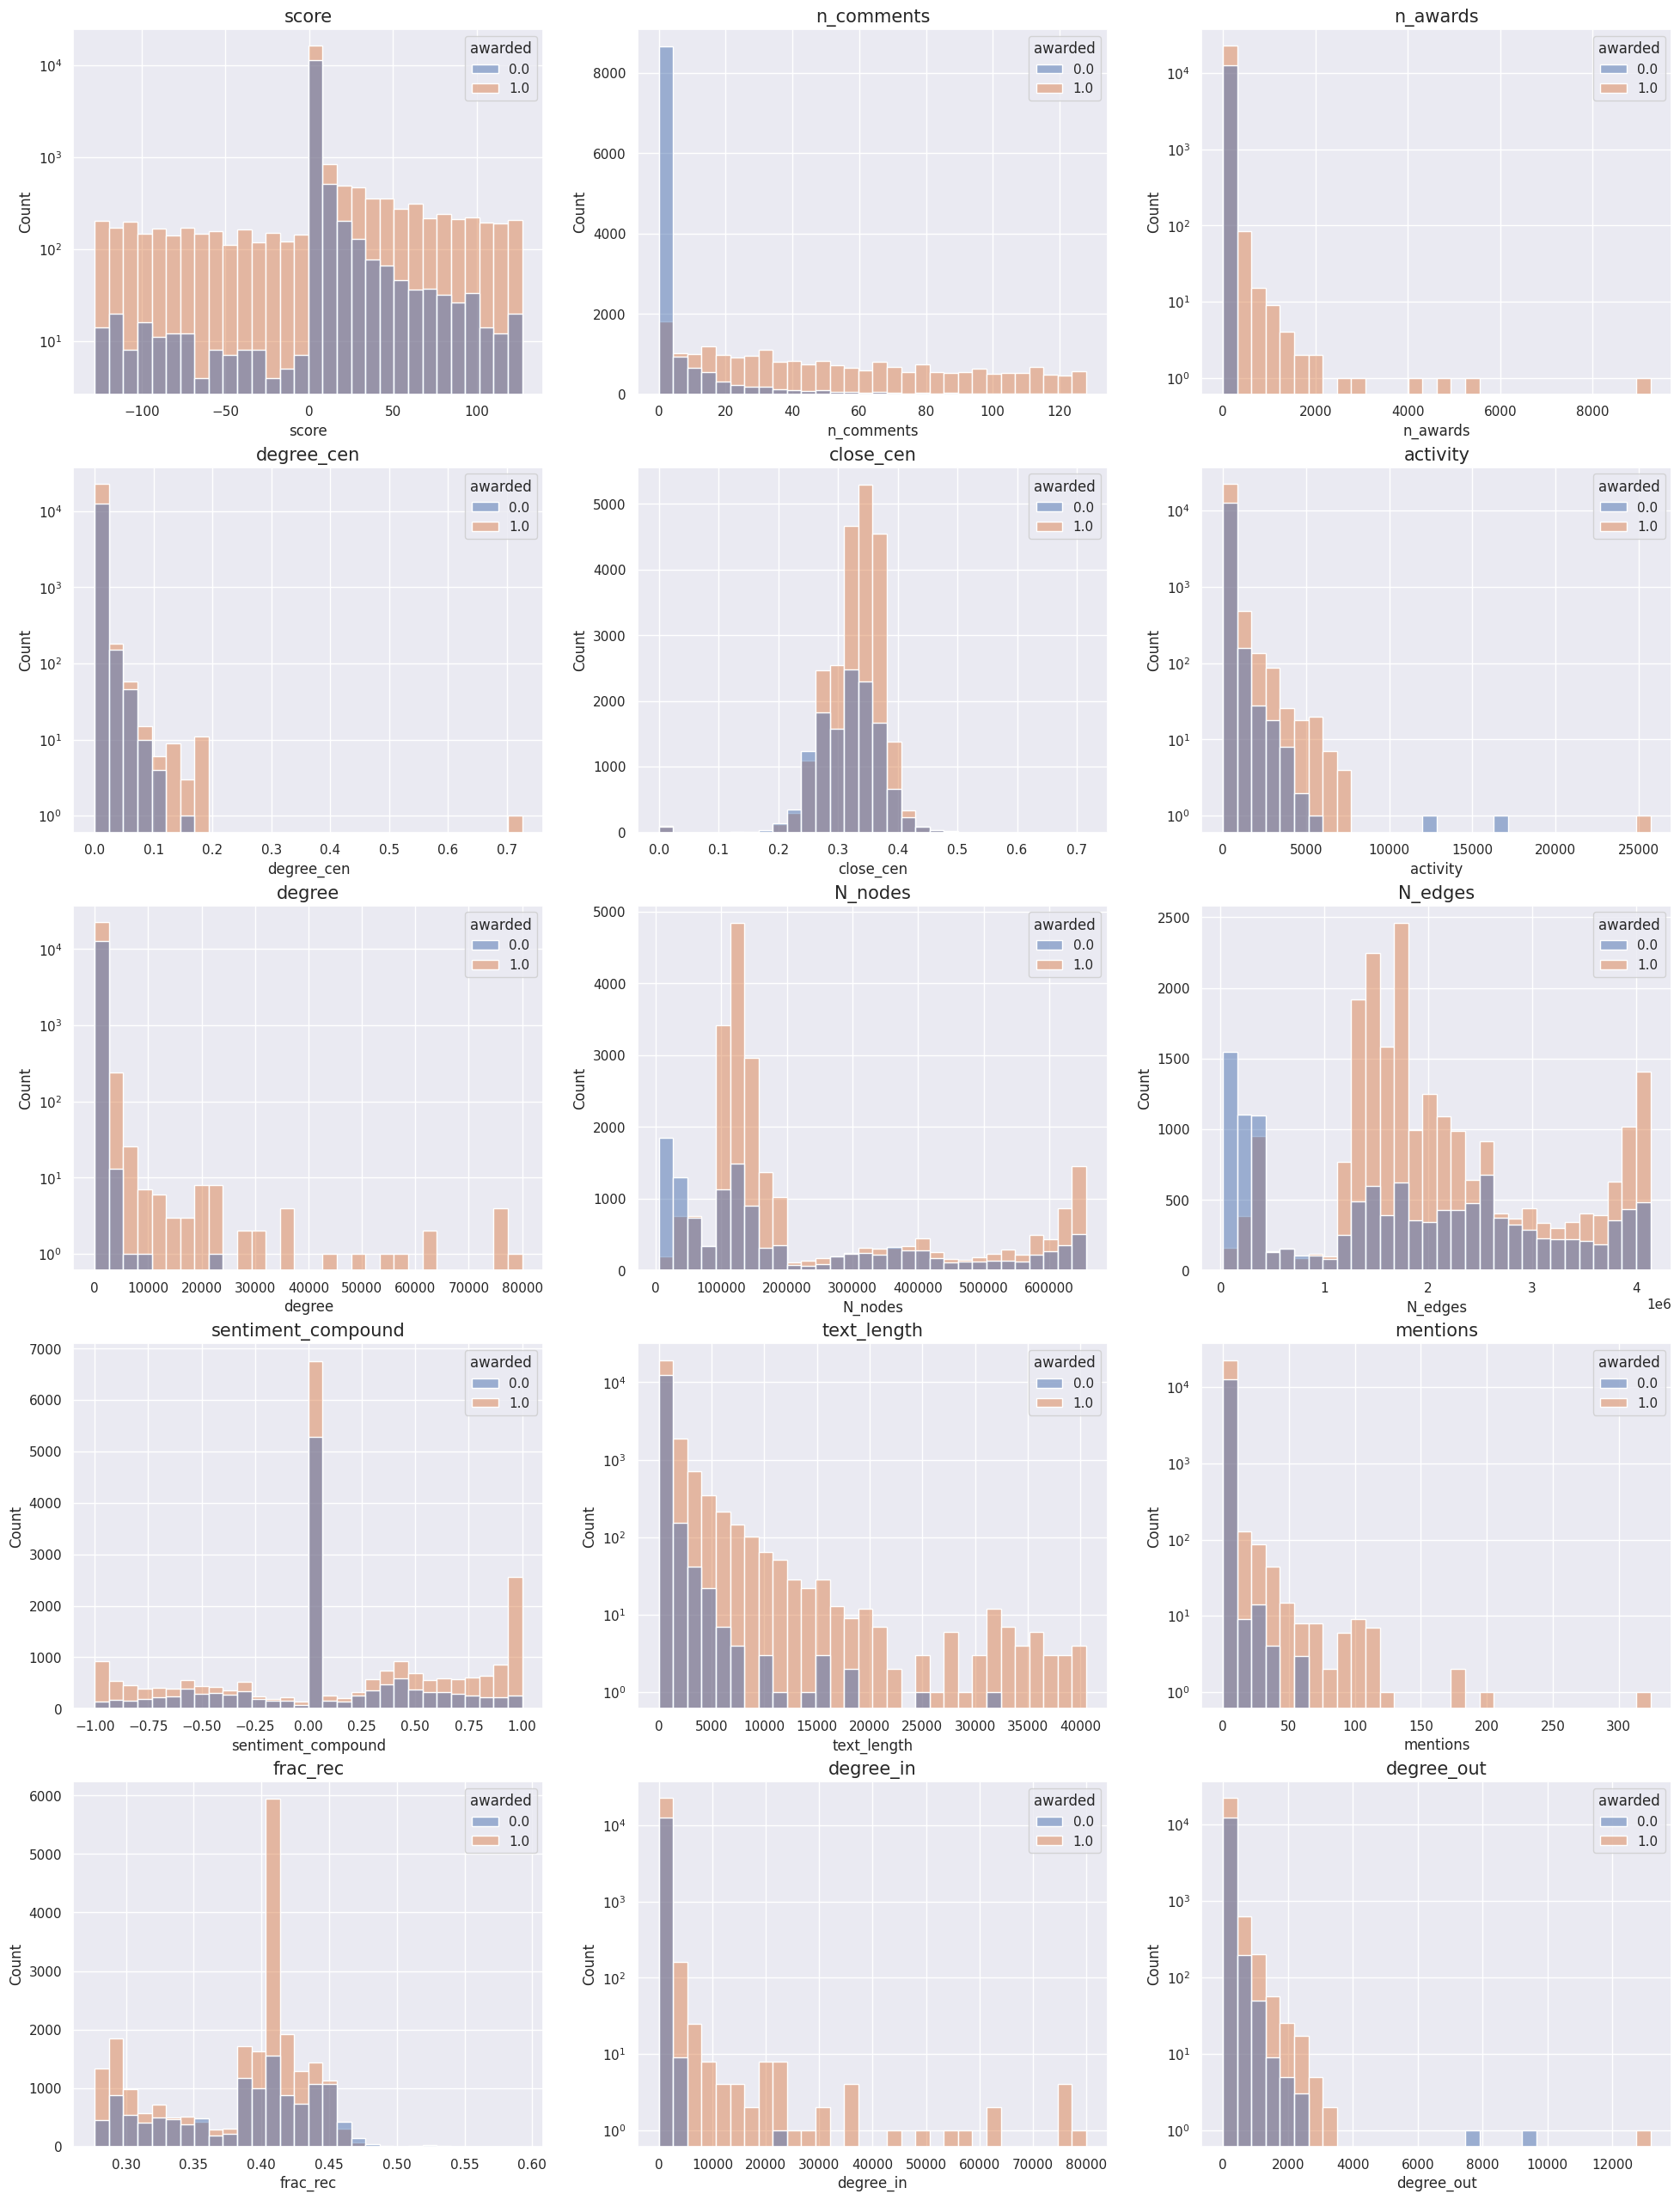

In [13]:
features = ['score', 'n_comments',  'n_awards', 'degree_cen', 'close_cen', 'activity', 'degree', 
            'N_nodes', 'N_edges', 'sentiment_compound', 'text_length', 
            'mentions','frac_rec','degree_in','degree_out']
            
log_features = ['score','n_awards', 'degree_cen', 'activity','degree','text_length','mentions','degree_in','degree_out']

fig, axs = plt.subplots(5, 3, figsize=(8*3,8*4))
axs = axs.flatten()

for i in range(len(features)):
    f = features[i]
    if f in log_features:
        sns.histplot(data=df_no, x=f, hue='awarded', ax=axs[i],bins=30)
        axs[i].set_yscale('log')
    else:
        sns.histplot(data=df_no, x=f, hue='awarded', ax=axs[i],bins=30)
    axs[i].set_title(f,fontsize=15)

plt.show()

<AxesSubplot:xlabel='N_nodes', ylabel='mentions'>

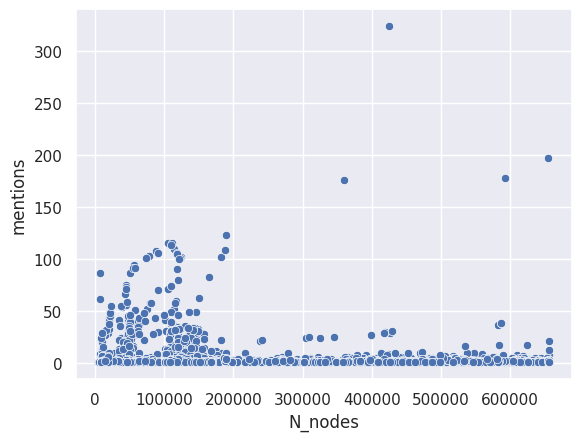

In [134]:
sns.scatterplot(data=df.loc[df['mentions']>0], x='N_nodes', y='mentions')

<AxesSubplot:xlabel='degree_in', ylabel='mentions'>

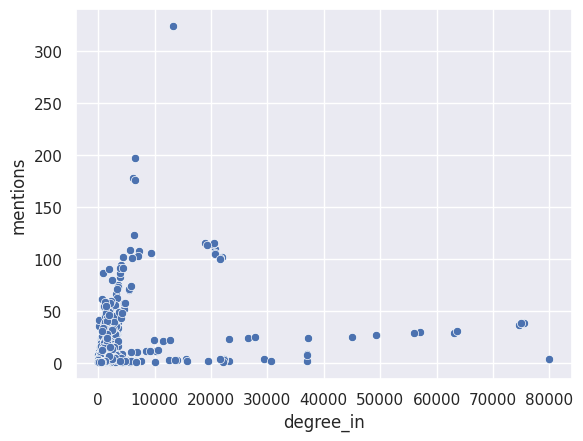

In [33]:
sns.scatterplot(data=df.loc[df['mentions']>0], x='degree_in', y='mentions')

In [15]:
# print(df.loc[df['text_length']>30000,'text_title'].sample(1).values)
print(df.loc[df['text_length']<100,'text_title'].sample(1).values)

['His stupid face says it all (CEO of RobbingYourHood) ']


<AxesSubplot:xlabel='N_nodes', ylabel='N_edges'>

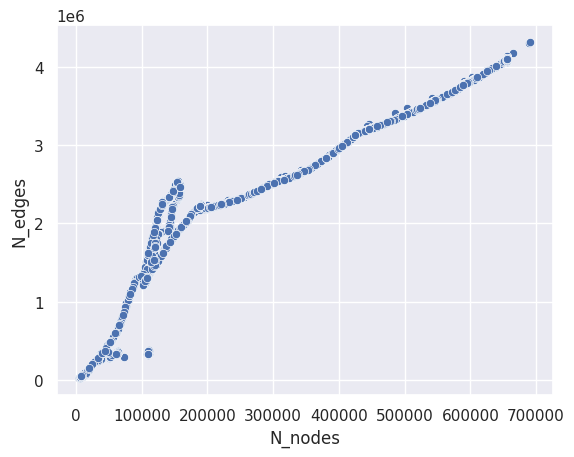

In [16]:
sns.scatterplot(data=df, x='N_nodes', y='N_edges')

## Rich get richer

In [128]:
top10=df.loc[df['n_awards']>0].groupby('author').agg({'n_awards':'sum'}).sort_values(by='n_awards',ascending=False).head(10)
top10

n_awards
author                        
DeepFuckingValue       19411.0
Youkiame                5279.0
SomeGuyInDeutschland    4224.0
OPINION_IS_UNPOPULAR    3766.0
ssauronn                2977.0
Lunar033                2976.0
wallstreetboyfriend     2660.0
IDoLikeMyShishkebabs    2654.0
shhaayy                 2053.0
dhiral1994              2019.0

In [130]:
df.loc[df.author.isin(top10.index)].groupby('author').count()['id'].sort_values(ascending=False)

author
dhiral1994              57
DeepFuckingValue        44
OPINION_IS_UNPOPULAR    34
IDoLikeMyShishkebabs    19
wallstreetboyfriend      8
Youkiame                 6
shhaayy                  4
ssauronn                 4
Lunar033                 2
SomeGuyInDeutschland     2
Name: id, dtype: int64

/tmp/ipykernel_5337/19691231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_df['N_awards_relative']=(top10_df['n_awards'] / top10_df['N_nodes'])


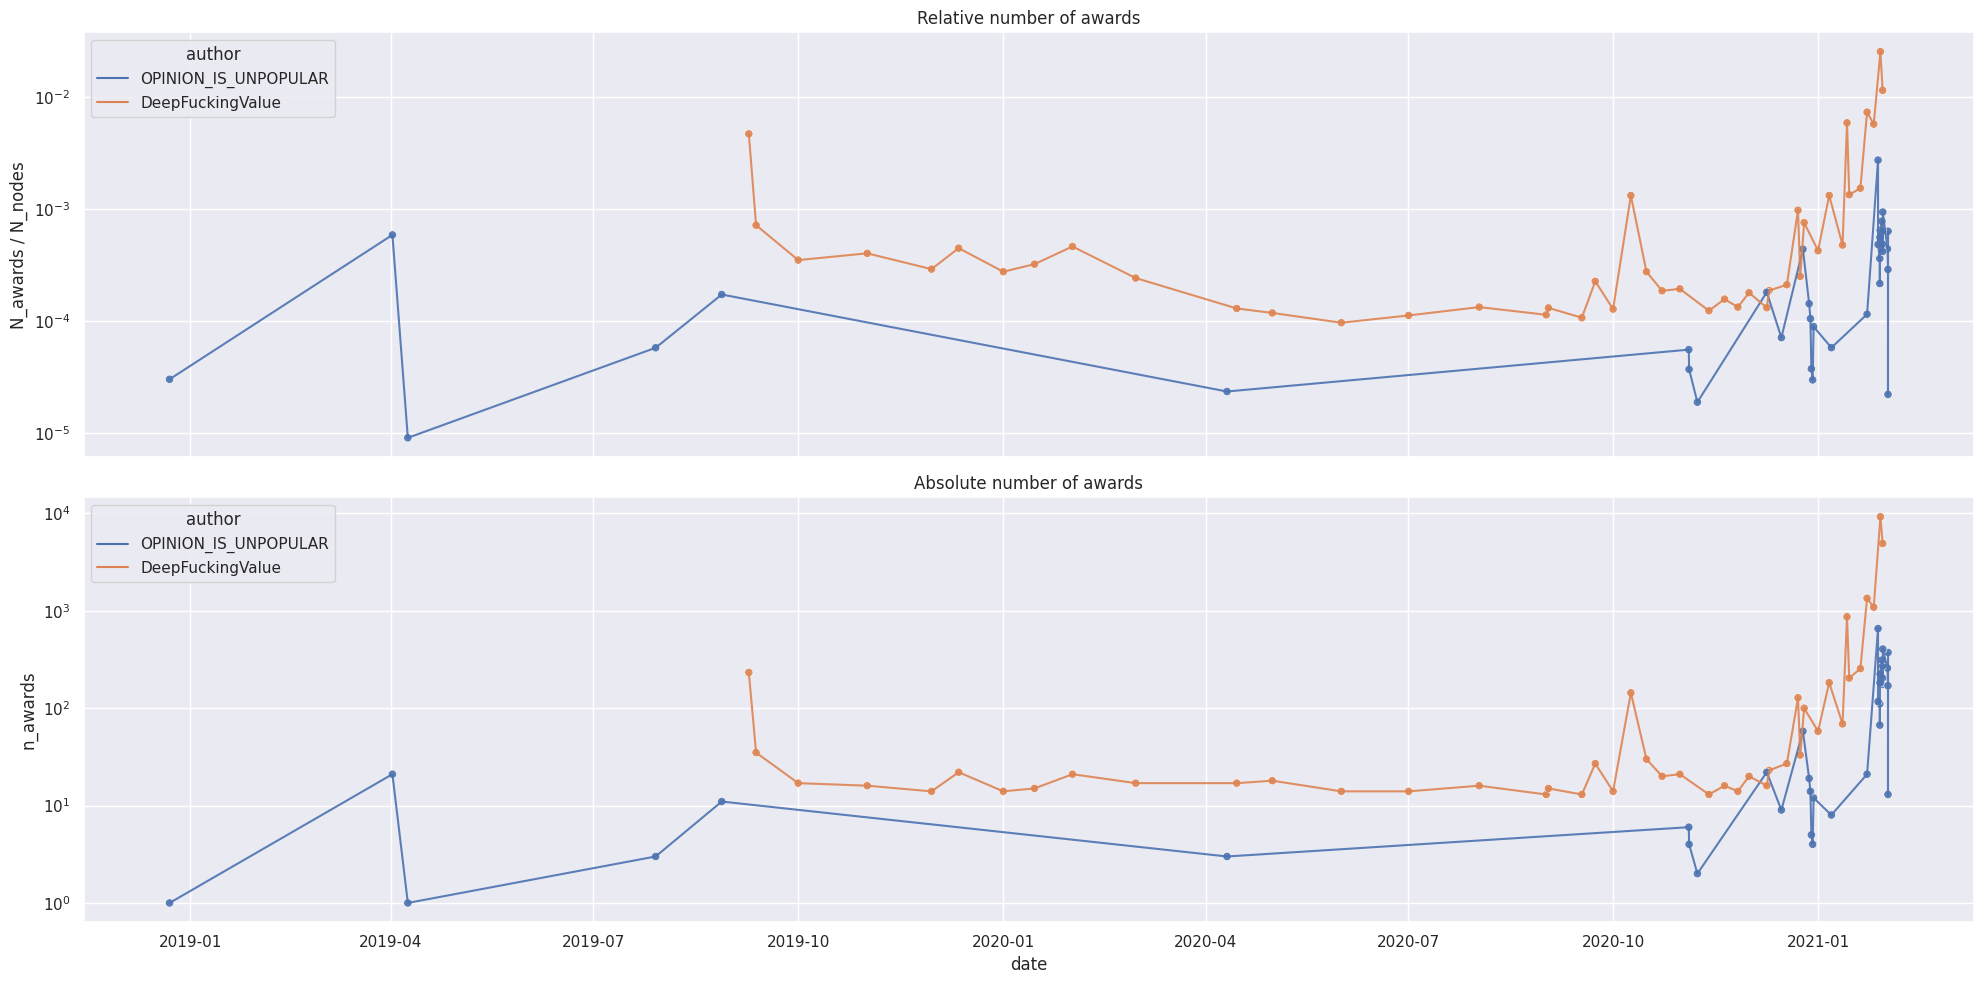

In [133]:
top10_df=df.loc[df['author'].isin(['DeepFuckingValue','OPINION_IS_UNPOPULAR'])]
top10_df['N_awards_relative']=(top10_df['n_awards'] / top10_df['N_nodes'])
# 2 suplots
fig, axs = plt.subplots(2, 1, figsize=(20,10), sharex=True)
axs.flatten()
sns.lineplot(data=top10_df, y='N_awards_relative', x='date', hue='author', ax=axs[0],alpha=0.9)
sns.scatterplot(data=top10_df, y='N_awards_relative', x='date', hue='author', ax=axs[0],color='black',alpha=0.9,legend=False)
axs[0].set_ylabel('N_awards / N_nodes')
axs[0].set_title('Relative number of awards')
axs[0].set_yscale('log')

sns.lineplot(data=top10_df, y='n_awards', x='date', hue='author', ax=axs[1],alpha=0.9)
sns.scatterplot(data=top10_df, y='n_awards', x='date', hue='author', ax=axs[1],color='black',alpha=0.9,legend=False)
axs[1].set_title('Absolute number of awards')
axs[1].set_yscale('log')
plt.tight_layout()
plt.show()


# PCA

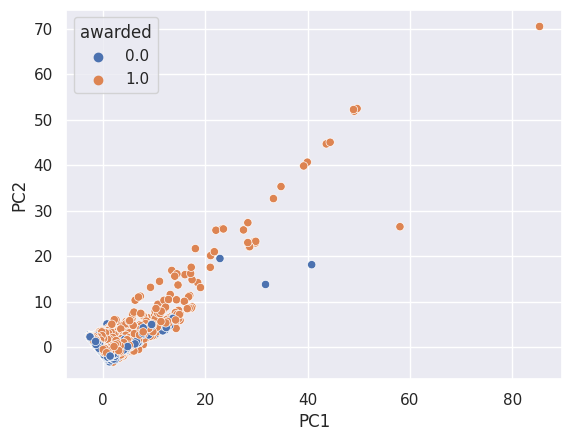

In [17]:
# pca
features = ['score', 'n_comments','degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions',
            'frac_rec','degree_in','degree_out']
scaler = StandardScaler()
scaler.fit(df[features])
df_scaled = scaler.transform(df[features])

pca = PCA(n_components=2)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

df_pca = pd.DataFrame(df_pca,columns=['PC1','PC2'])
df_pca['awarded'] = df['awarded'].values

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='awarded')
plt.show()

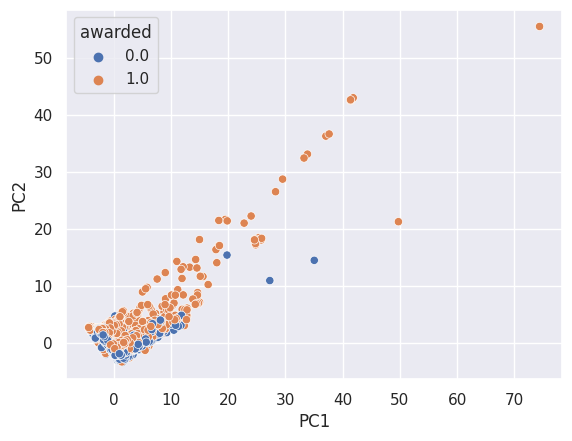

In [18]:
# pca
features = ['score', 'n_comments','degree_cen', 'close_cen', 'activity', 'degree',
             'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions',
             'frac_rec','degree_in','degree_out']
scaler = StandardScaler()
scaler.fit(df_no[features])
df_no_scaled = scaler.transform(df_no[features])

pca = PCA(n_components=2)
pca.fit(df_no_scaled)
df_no_pca = pca.transform(df_no_scaled)

df_no_pca = pd.DataFrame(df_no_pca,columns=['PC1','PC2'])
df_no_pca['awarded'] = df_no.awarded.values

sns.scatterplot(data=df_no_pca, x='PC1', y='PC2', hue='awarded')
plt.show()

# Random Forrest

In [27]:
features = ['degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions','frac_rec','degree_in','degree_out']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)
test, val = train_test_split(test, test_size=0.5, random_state=42)

# split data into X and y
X_train = train[features]
y_train = train['awarded']
X_test = test[features]
y_test = test['awarded']
X_val = val[features]
y_val = val['awarded']

# normalize train data
scaler = StandardScaler()
scaler.fit(df[features])
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)


In [20]:
L = len(X_train)+len(X_test)+len(X_val)
print('Train: {:.2f}%'.format(len(X_train)/L*100))
print('Test: {:.2f}%'.format(len(X_test)/L*100))
print('Validation: {:.2f}%'.format(len(X_val)/L*100))

Train: 80.00%
Test: 10.00%
Validation: 10.00%


F1: 0.7806297056810404
Accuracy: 0.7483313702394975


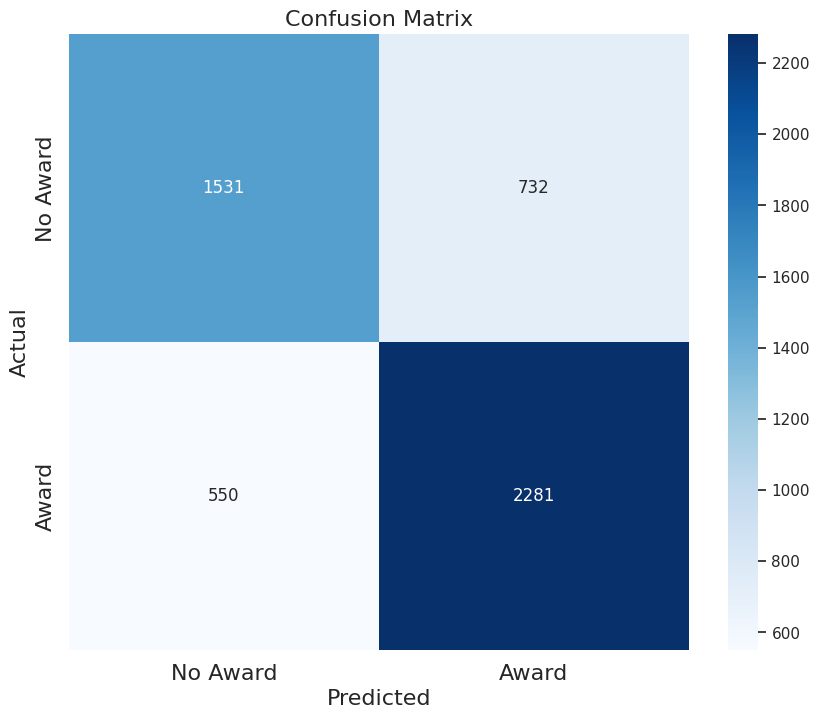

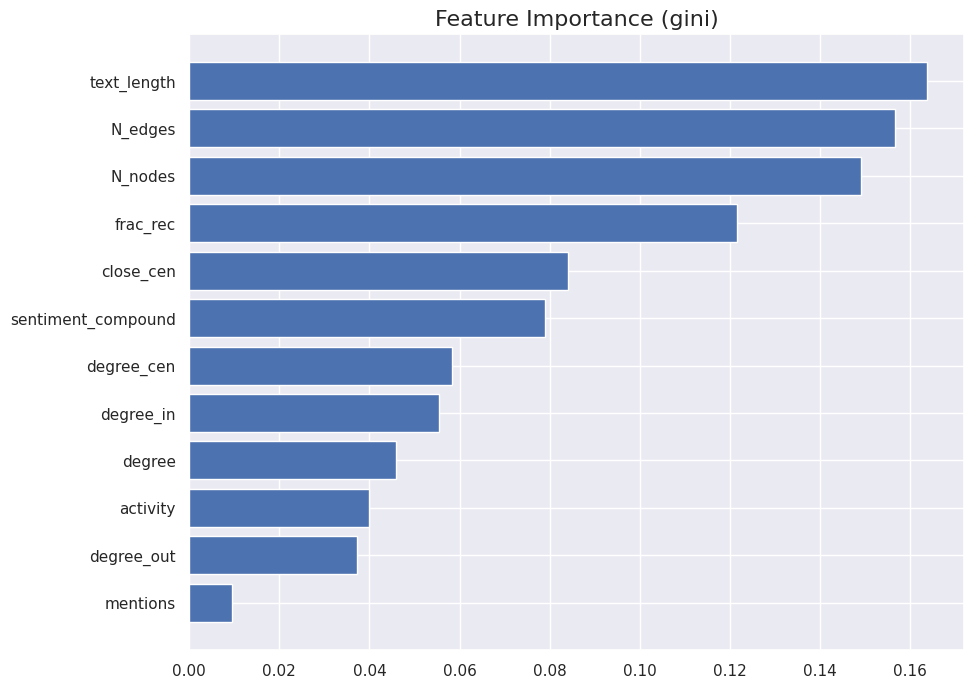

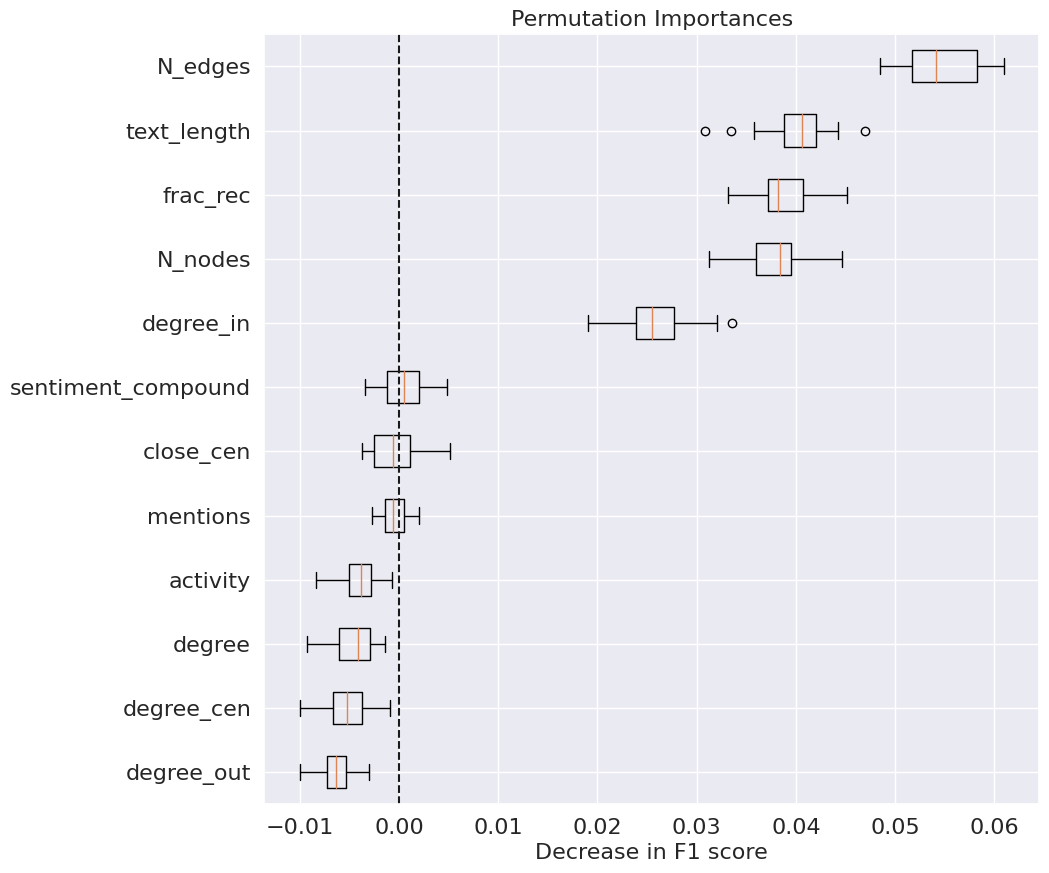

In [21]:
# create model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# fit model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

print('F1: ' + str(f1_score(y_test, y_pred.round())))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred.round())))

#Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xticks([0.5,1.5], ['No Award', 'Award'], fontsize=16)
plt.yticks([0.5,1.5], ['No Award', 'Award'],fontsize=16)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# permutation importance
result = permutation_importance(rf, X_test, y_test,
                            n_repeats=30,
                            random_state=0,
                            scoring='f1')

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx])

plt.figure(figsize=(10,8))
importance = rf.feature_importances_
idx = np.argsort(importance)
plt.barh([x for x in X_train.columns[idx]], importance[idx])
plt.tick_params(axis='x', labelrotation = 0)
plt.title('Feature Importance (gini)', fontsize=16)
plt.show()

# plot permutation importance
plt.figure(figsize=(10,10))
plt.boxplot(importances, vert=False, labels=importances.columns)
# label size
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title("Permutation Importances", fontsize=16)
plt.axvline(x=0, color="k", linestyle="--")
plt.xlabel("Decrease in F1 score",  fontsize=16)
plt.show()

## RF normalized

F1: 0.7825042881646656
Accuracy: 0.7510797016097369


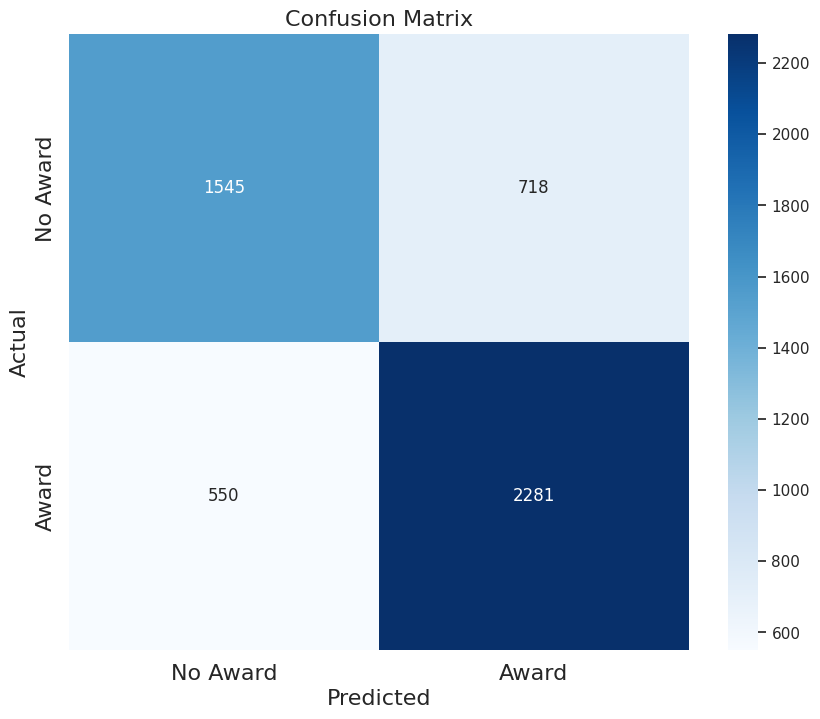

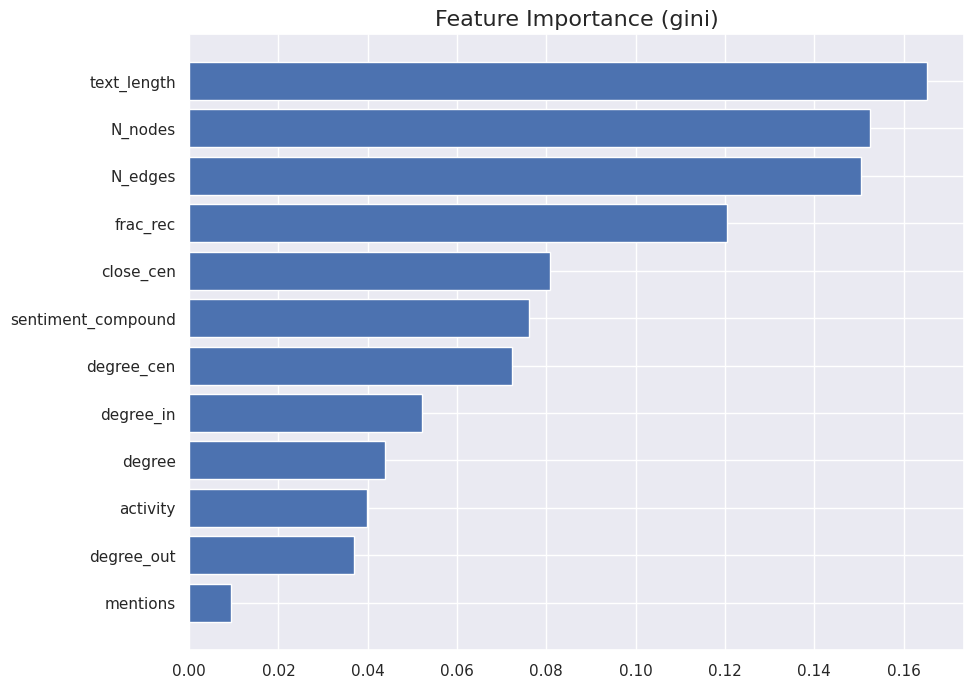

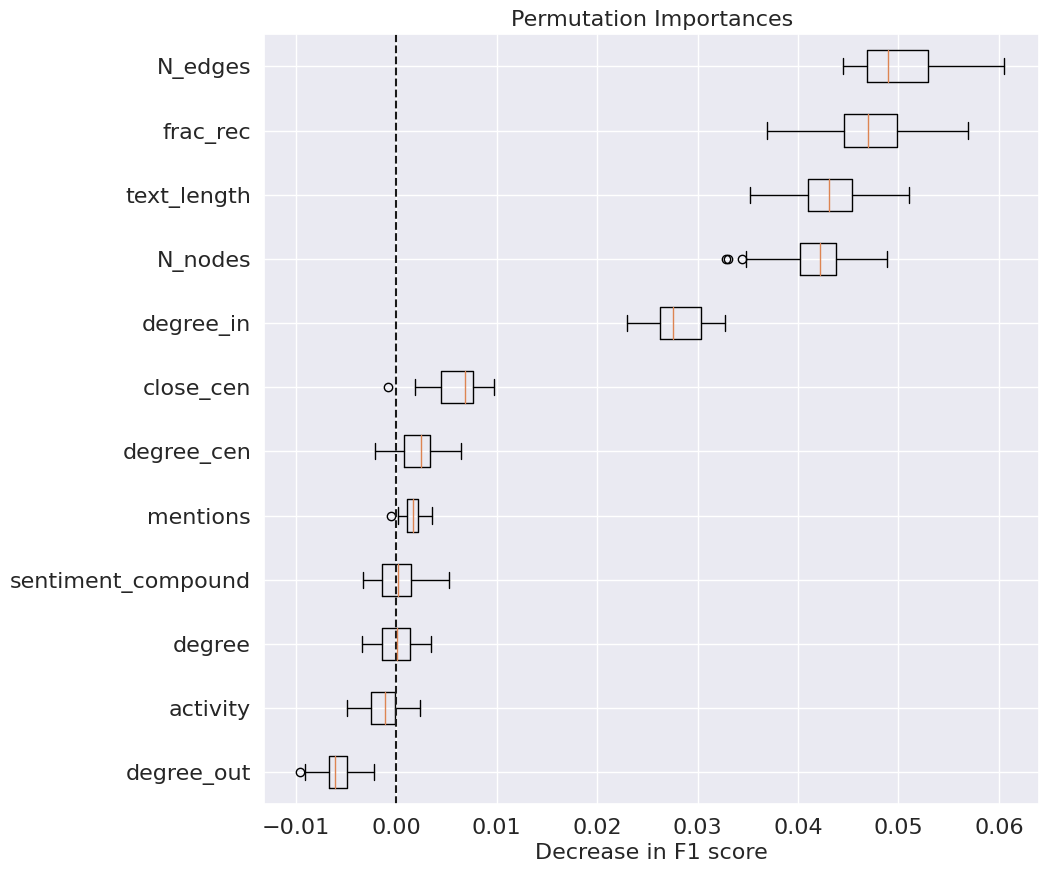

In [31]:
# create model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# fit model
rf.fit(X_train_norm, y_train)

# predict
y_pred = rf.predict(X_test_norm)

print('F1: ' + str(f1_score(y_test, y_pred.round())))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred.round())))

#Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xticks([0.5,1.5], ['No Award', 'Award'], fontsize=16)
plt.yticks([0.5,1.5], ['No Award', 'Award'],fontsize=16)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# permutation importance
result = permutation_importance(rf, X_test_norm, y_test,
                            n_repeats=30,
                            random_state=0,
                            scoring='f1')

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx])

plt.figure(figsize=(10,8))
importance = rf.feature_importances_
idx = np.argsort(importance)
plt.barh([x for x in X_train.columns[idx]], importance[idx])
plt.tick_params(axis='x', labelrotation = 0)
plt.title('Feature Importance (gini)', fontsize=16)
plt.show()

# plot permutation importance
plt.figure(figsize=(10,10))
plt.boxplot(importances, vert=False, labels=importances.columns)
# label size
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title("Permutation Importances", fontsize=16)
plt.axvline(x=0, color="k", linestyle="--")
plt.xlabel("Decrease in F1 score",  fontsize=16)
plt.show()

## XGboost

In [22]:
# # XGBoost
# # create model
# from xgboost import XGBClassifier
# xgbClass = XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='f1')

# xgbClass.fit(X_train, y_train)

# # predict
# y_pred = xgbClass.predict(X_test)

# print('F1: ' + str(f1_score(y_test, y_pred.round())))
# print('Accuracy: ' + str(accuracy_score(y_test, y_pred.round())))

# #Confusion Matrix
# plt.figure(figsize=(10,8))
# cm = confusion_matrix(y_test, y_pred.round())
# sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # permutation importance
# result = permutation_importance(xgbClass, X_test, y_test,
#                             n_repeats=30,
#                             random_state=0,scoring='f1')

# sorted_importances_idx = result.importances_mean.argsort()
# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=X_test.columns[sorted_importances_idx])

# # subplot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

# importance = xgbClass.feature_importances_
# idx = np.argsort(importance)
# ax1.barh([x for x in X_train.columns[idx]], importance[idx])
# ax1.tick_params(axis='x', labelrotation = 0)
# ax1.set_title('Feature Importance (gini)')

# # plot permutation importance
# ax2.boxplot(importances, vert=False, labels=importances.columns)
# ax2.set_title("Permutation Importances")
# ax2.axvline(x=0, color="k", linestyle="--")
# ax2.set_xlabel("Decrease in F1 score")
# ax2.figure.tight_layout()

# plt.show()

F1: 0.7606768734891217
Accuracy: 0.7084805653710248


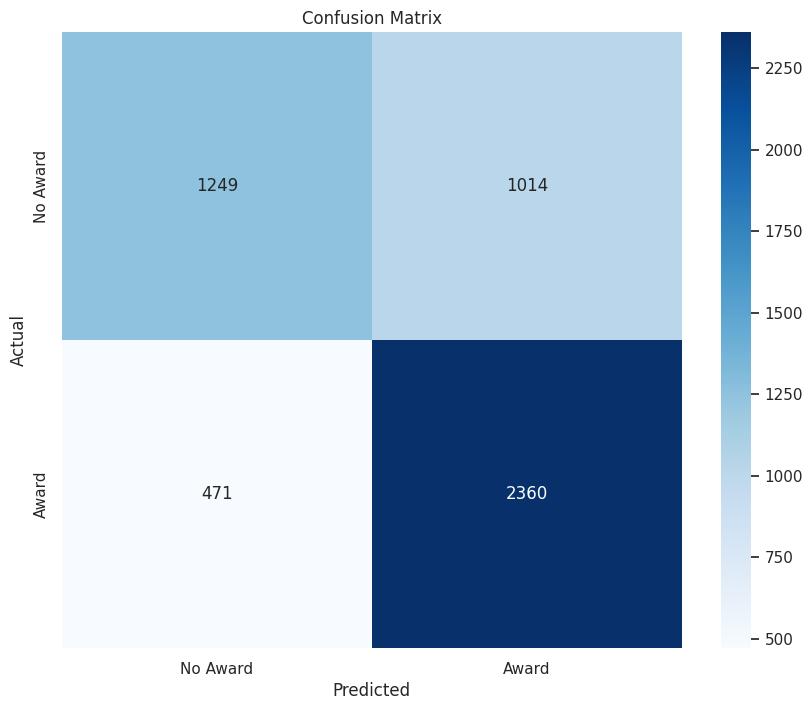

In [23]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300,hidden_layer_sizes=(512,50))

# fit model
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

print('F1: ' + str(f1_score(y_test, y_pred.round())))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred.round())))

#Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xticks([0.5,1.5], ['No Award', 'Award'])
plt.yticks([0.5,1.5], ['No Award', 'Award'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Log reg

F1: 0.7095924376259104


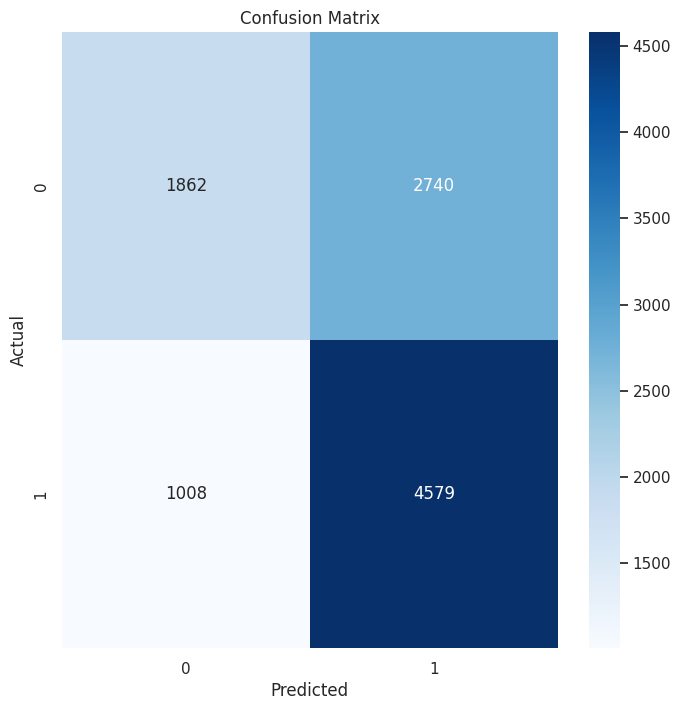

In [24]:
# logistic regression
from sklearn.linear_model import LogisticRegression

features = ['degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2)

# split data into X and y
X_train = train[features]
y_train = train['awarded']
X_test = test[features]
y_test = test['awarded']

# create model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# predict
y_pred = logreg.predict(X_test)

print('F1: ' + str(f1_score(y_test, y_pred.round())))


plt.figure(figsize=(8,8))
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Regression model

R2: -0.24409574087732677
RMSE: 59.29841201302193


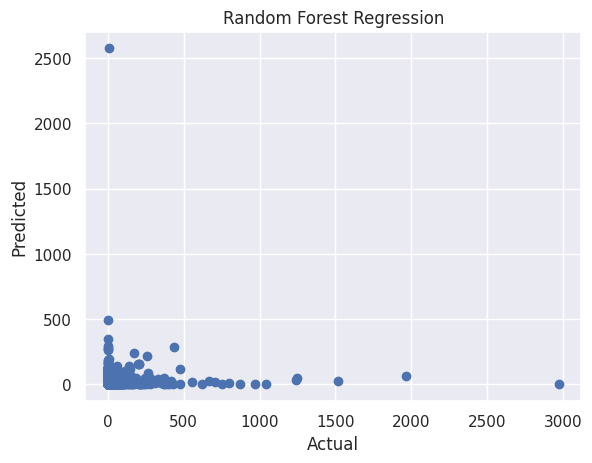

In [25]:
# random forrest regression
from sklearn.ensemble import RandomForestRegressor

features = ['score', 'degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2)

# split data into X and y
X_train = train[features]
y_train = train['n_awards']
X_test = test[features]
y_test = test['n_awards']

# create model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# calculate mean squared error
print('R2: ' + str(r2_score(y_test, y_pred)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test, y_pred))))

#plot 
plt.scatter(x=y_test.values,y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Regression')
plt.show()

R2: -0.13477894877049534
RMSE: 51.3474657110819


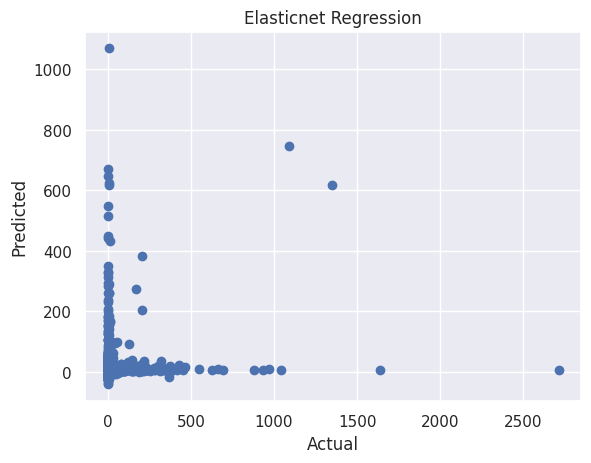

In [26]:
# elastic net regression
from sklearn.linear_model import ElasticNet

features = ['score', 'degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2)

# split data into X and y
X_train = train[features]
y_train = train['n_awards']
X_test = test[features]
y_test = test['n_awards']

# create model
regr = ElasticNet(random_state=0)
regr.fit(X_train, y_train)

# predict
y_pred = regr.predict(X_test)

# calculate mean squared error
print('R2: ' + str(r2_score(y_test, y_pred)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test, y_pred))))

#plot 
plt.scatter(x=y_test.values,y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Elasticnet Regression')
plt.show()
